# Presentation

Ce notebook permet de récupérer et pré-processer les données de course disponibles sur internet pour la Asics Sainté Lyon 2024, ainsi que toute autre donnée qui pourrait être utile pour analyser les résultats de cette denière.

- Input : le csv des résultats, les url des sites internets permettant de récupérer des informations complémentaires.
- Output : Des csv contenant les données scrappées et traîtées, prêtes pour l'analyse.

In [5]:
VERBOSE = True
RUN_SCRAPPING = False
SAVE = False

## 0. Imports

In [6]:
import sys
from pathlib import Path

# Definition du chemin vers notre code source local
sys.path.append(str(Path().resolve().parent))

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from src.definitions import RAW_DATA_PATH, CLEAN_DATA_PATH, CHROMEDRIVER_PATH
from src.scrapping import scrap_itra_index
from src.utils import clean_athlete_names, extract_sexe_from_categorie, time_to_seconds

## 1. Les résultats de la course

Nous pourrions scrapper les résultats de la course sur des sites où ils sont publiques, comme des sites de résultats tels que BeTrail, le site organisateur (Asics Sainté Lyon) ou encore le site du chronométreur (LiveTrail). 

Néanmoins ici ce n'est pas nécessaire car tous les résultats LiveTrail sont récupérables directement sous format csv. Les données brutes sont stockées dans `data/raw`.

In [8]:
race_results_df = pd.read_csv(RAW_DATA_PATH / "final_raw.csv")

In [9]:
if VERBOSE:
    display(race_results_df)

,classement,dossard,nom,club,categorie,classement_categorie,temps,ecart_premier,nationalite
0,1,5,Thomas CARDIN,NaN,SE-M0H,1,05:52:21,00:00:00,FRA (France)
1,2,10,Ben DHIMAN,NaN,SE-M0H,2,06:03:25,00:11:04,USA (Etats-Unis)
2,3,6,Andrzej WITEK,ASICS FUJI TRAIL,SE-M0H,3,06:12:09,00:19:48,POL (Pologne)
3,4,24,Virgile MORISET,NaN,SE-M0H,4,06:12:57,00:20:36,FRA (France)
4,5,14,Antoine CHARVOLIN,Team ON,SE-M0H,5,06:12:58,00:20:37,FRA (France)
...,...,...,...,...,...,...,...,...,...
6247,6248,9825,♀\r\nSandrine PAILLET,NaN,M3-M4F,87,17:12:43,11:20:22,FRA (France)
6248,6248,9826,Eric PAILLET,NaN,M3-M4H,722,17:12:43,11:20:22,FRA (France)
6249,6250,5029,Philippe LAURANTIN,NaN,M5-M6H,125,17:20:19,11:27:58,FRA (France)
6250,6251,6747,Franck FERRUA,Saint Cyp runner / CA team,M1-M2H,1397,17:30:10,11:37:49,FRA (France)


On remarque tout de suite que les noms des femmes sont précédées des caractères "♀\r\n", ce qui n'est pas souhaitable.

In [10]:
race_results_df["nom"] = race_results_df["nom"].apply(clean_athlete_names)

On peut néanmoins conserver l'information dans une colonne sexe.

In [11]:
race_results_df["sexe"] = race_results_df["categorie"].apply(extract_sexe_from_categorie)

On peut également transformer tous les temps en secondes

In [12]:
race_results_df["temps"] = race_results_df["temps"].apply(time_to_seconds)
race_results_df["ecart_premier"] = race_results_df["ecart_premier"].apply(time_to_seconds)

On peut utiliser la variable `club` pour obtenir une autre variable `en_club` qui permet de savoir si un athlète possède un club ou non. En effet, la variable `club` a trop peu d'éléments positifs différents pour que son analyse en l'état ai un grand intérêt. Néanmoins, il faudra prendre cette variable avec des pincettes car la variable `club` semble être partiellement bien définie. En effet, on vois qu'elle correspond parfois à un club, parfois à un équipementier. De plus, tous les athlètes ne semblent pas avoir renseignés leurs informations à ce sujet. Par exemple, le vainqueur Thomas Cardin fait partie de la team Kiprun, mais ce n'est pas indiqué.

In [13]:
race_results_df["club"] = race_results_df["club"].notna().astype(int)

Enfin, je suis parvenu à extraire les données à "mi-course" au checkpoint de Saint-Genou. Je vais donc les ajouter au dataset de résultats. 

In [14]:
inter_results_df = pd.read_csv(RAW_DATA_PATH / "saint-genou_raw.csv").drop(columns=["nom", "categorie", "nationalite"])

inter_results_df["temps_inter"] = inter_results_df["temps_inter"].apply(time_to_seconds)
inter_results_df["ecart_premier_inter"] = inter_results_df["ecart_premier_inter"].apply(time_to_seconds)

In [15]:
race_results_df = pd.merge(race_results_df, inter_results_df, on=["dossard"])

Je vais en profiter pour définir les variables nommées `negative_split`, `positive_split` et `equal_split`. Etant donné qu'on parle de trail, on ne peut pas les définir comme sur un 10km sur route, en comparant simplement les temps du premier et du deuxième 5km. 

Une première idée était d'utiliser l'évolution du classement d'un athlète pour définir son split (augmentation de X places par exemple), néanmoins le phénomène d'abandons empêche cette approche. En effet, plus un athlète termine mal classé, plus il y a de chances que son classement ai favorablement évoluer car plus d'athlètes ont abandonnés avant lui.

Nous allons donc utiliser une seconde approche, qui permet de contourner le problème des abandons. Pour cela, on va comparer le pourcentage d'écart entre le temps de l'athlète sur le segment au temps moyen sur le segment et on va considérer qu'un athlète réalise un negative split si ce pourcentage diminue.

Ainsi, je définis:
- negative split : si l'athlète est allé au moins 2% plus vite sur la deuxième moitié de course proportionnelement aux autres athlètes.
- positive split : si l'athlète est allé au moins 2% plus lentement sur la deuxième moitié de course proportionnelement aux autres athlètes.
- equal split : si l'athlète n'a fait ni l'un ni l'autre

Je vais également ajouter une version `large` de ces variables, qui est définie comme un gain / une perte de 5% par rapport la moyenne et qui permet de connaître les athlètes ayant réalisés de grands negative ou positive splits.

Ces métriques ont un biais supplémentaires par rapport à l'analyse des splits habituels : elles dépendent des performances des autres athlètes. C'est pour cela que la définition utilise un écart minimal de positions, afin de réduire l'impact des autres sur sa propre analyse. Par contre, la métrique a l'avantage de comparer directement des athlètes entre eux.

In [16]:
split_percentage_difference = (
    (
        race_results_df["temps_inter"]
        / race_results_df["temps_inter"].mean()
    ) - (
        (race_results_df["temps"] - race_results_df["temps_inter"])
        / (race_results_df["temps"] - race_results_df["temps_inter"]).mean()
    )
)

race_results_df["negative_split"] = (split_percentage_difference >= 0.02).astype(int)
race_results_df["positive_split"] = (split_percentage_difference <= -0.02).astype(int)
race_results_df["equal_split"] = ((race_results_df["negative_split"]==0) & (race_results_df["positive_split"]==0)).astype(int)

race_results_df["negative_split_large"] = (split_percentage_difference >= 0.05).astype(int)
race_results_df["positive_split_large"] = (split_percentage_difference <= -0.05).astype(int)
race_results_df["equal_split_large"] = ((race_results_df["negative_split_large"]==0) & (race_results_df["positive_split_large"]==0)).astype(int)

In [17]:
if VERBOSE:
    display(race_results_df)

,classement,dossard,nom,club,categorie,classement_categorie,temps,ecart_premier,nationalite,sexe,classement_inter,temps_inter,ecart_premier_inter,negative_split,positive_split,equal_split,negative_split_large,positive_split_large,equal_split_large
0,1,5,Thomas CARDIN,0,SE-M0H,1,21141,0,FRA (France),H,1,12514,0,1,0,0,0,0,1
1,2,10,Ben DHIMAN,0,SE-M0H,2,21805,664,USA (Etats-Unis),H,2,12566,51,0,0,1,0,0,1
2,3,6,Andrzej WITEK,1,SE-M0H,3,22329,1188,POL (Pologne),H,3,12653,139,0,1,0,0,0,1
3,4,24,Virgile MORISET,0,SE-M0H,4,22377,1236,FRA (France),H,6,12915,400,0,0,1,0,0,1
4,5,14,Antoine CHARVOLIN,1,SE-M0H,5,22378,1237,FRA (France),H,4,12697,182,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6137,6247,10133,Morgane MAIRE,0,SE-M0F,401,61928,40787,FRA (France),F,6350,33344,20829,0,1,0,0,1,0
6138,6248,9825,Sandrine PAILLET,0,M3-M4F,87,61963,40822,FRA (France),F,6409,34380,21865,0,1,0,0,1,0
6139,6248,9826,Eric PAILLET,0,M3-M4H,722,61963,40822,FRA (France),H,6408,34377,21862,0,1,0,0,1,0
6140,6251,6747,Franck FERRUA,1,M1-M2H,1397,63010,41869,FRA (France),H,6446,35725,23210,0,1,0,0,1,0


## 2. La météo

Des recherches web rapides nous permettent d'avoir des estimations de la météo au départ de la course pour différentes années. Il existe par exemple des API qui permettent de retrouver les données du passé. Pour cette étude j'ai utilisé celle d'infoclimat (https://www.infoclimat.fr/observations-meteo/archives/).

Nous ajoutons aux données météo le temps du vainqueur, le temps du 10ème ainsi que la distance de la course afin de pouvoir comparer les années entre elles.

Nous conservons ces résultats dans `data/meteo.csv`.

In [18]:
meteo_data = {
    "annee": [2021, 2022, 2023, 2024],
    "temperature": [0.3, 2.9, -1.5, -1.1], # degrés celsius
    "ressenti": [-2.1, 2.4, -4.2, -1.5], # degrés celsius
    "pluie": [0, 0, 0, 0], # binaire
    "verglas_neige_abondante": [0, 0, 1, 0], # binaire
    "temps_vainqueur": [
        time_to_seconds("5:56:36"),
        time_to_seconds("5:47:35"),
        time_to_seconds("5:41:56"),
        time_to_seconds("5:52:21"),
    ], # minutes
    "temps_dixieme": [
        time_to_seconds("6:47:22"),
        time_to_seconds("6:41:43"),
        time_to_seconds("6:14:54"),
        time_to_seconds("6:30:50"),
    ], # minutes
    "distance_course": [77, 78, 77, 81], # km
    "denivele_course": [2300, 2300, 2300, 2500], # m
}
meteo_df = pd.DataFrame(meteo_data)

In [19]:
if VERBOSE:
    display(meteo_df)

,annee,temperature,ressenti,pluie,verglas_neige_abondante,temps_vainqueur,temps_dixieme,distance_course,denivele_course
0,2021,0.3,-2.1,0,0,21396,24442,77,2300
1,2022,2.9,2.4,0,0,20855,24103,78,2300
2,2023,-1.5,-4.2,0,1,20516,22494,77,2300
3,2024,-1.1,-1.5,0,0,21141,23450,81,2500


## 3. Scrapper les index ITRA des athlètes

En trail il existe deux indexes de performance connus: l'index UTMB et l'index ITRA. J'ai choisi d'utiliser l'Index ITRA car je le connais mieux. L'objectif de cette partie est de scrapper automatiquement les indexes des athlètes figurants dans le classement de la Saint& Lyon 2024.

`ATTENTION`: Les indexes sont ceux au 18 janvier 2025. Nous faisons l'hypothèse qu'ils sont représentatif du niveau des athlètes fin 2024, donc il y a 45 jours. Pour les athlètes stables cela paraît être une hypothèse faible, mais pour les athlètes en progression, en particulier ceux qui ont réalisé un bon score lors de cette course, cela introduit un biais positif.

In [20]:
### Cette cellule nécessite le téléchérgement préalable d'un ChromeDriver compatible avec votre version de Google Chrome.
### Si jamais celui installé ici ne fonctionne pas : https://googlechromelabs.github.io/chrome-for-testing/#stable
### Il faut ensuite remplacer CHROMEDRIVER_PATH par le votre.
### Enfin, vous pouvez set RUN_SCRAPPING = True pour faire tourrner le scrappeur.
###
### Sinon, je télécharge le fichier préalablement créé tel qu'il serait après le scrapping (recommandé).

if RUN_SCRAPPING:
    indexes = scrap_itra_index(list(race_results_df["nom"]), CHROMEDRIVER_PATH)
    index_df = pd.DataFrame(indexes)
    race_results_df = pd.merge(race_results_df, index_df, how="outer", on="nom")
else:
    race_results_df = pd.read_csv(CLEAN_DATA_PATH / "race_results.csv")
    race_results_df.drop(columns=["index_correct"])

Je sais que le scrapper n'a pas fonctionné pour tous les athlètes. Ainsi une analyse rapide des erreurs s'impose.

In [21]:
# Analyse des NaNs
if VERBOSE:
    display(race_results_df.isna().sum())

classement                 0
dossard                    0
nom                        0
club                       0
categorie                  0
classement_categorie       0
temps                      0
ecart_premier              0
nationalite                0
classement_inter           0
temps_inter                0
ecart_premier_inter        0
negative_split             0
positive_split             0
equal_split                0
negative_split_large       0
positive_split_large       0
equal_split_large          0
index                   1738
index_correct              0
sexe                       0
dtype: int64

On peut voir que 1738 index n'ont pas pu être récupérés. Regardons aussi si certains indexes récupérés pourraient être faux.

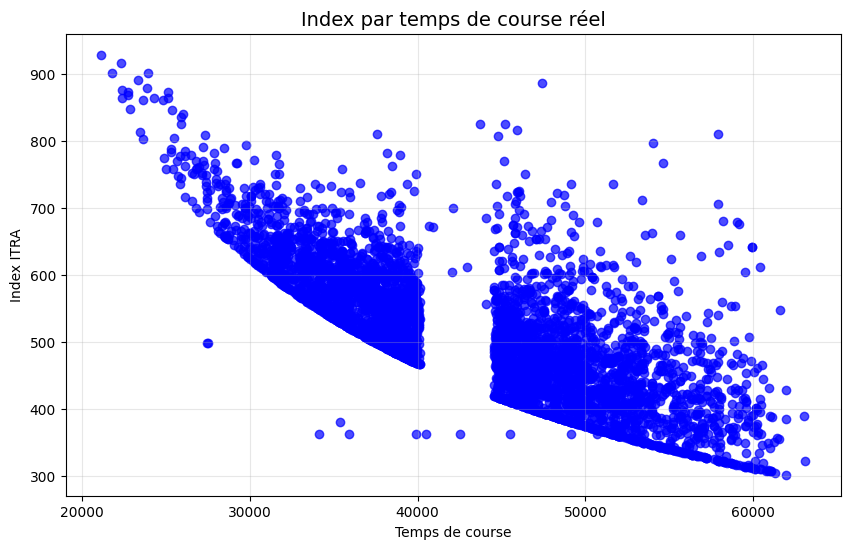

In [22]:
# visualisation de l'ensemble des points

plt.figure(figsize=(10, 6))
plt.scatter(race_results_df["temps"], race_results_df["index"], alpha=0.7, color="blue")
plt.title("Index par temps de course réel", fontsize=14)
plt.xlabel("Temps de course", fontsize=10)
plt.ylabel("Index ITRA", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

On remarque immédiatement que les indexes pour les temps de course entre 41000 secondes et 44000 secondes environ n'ont pas été bien scrappés. C'est sûrement ici que se situent la majortié de nos points manquants. Le scrapper prenant longtemps à tourner, je n'ai pas le temps de réessayer de le lancer ou de comprendre pourquoi. Nous allons donc nous en contenter.

De plus certains points semblent aberrants. Le scrapper peut générer des erreurs d'index pour 3 raisons principales :
1. Une recherche n'a pas fonctionnée
2. Une recherche fonctionne mais l'index sélectionné est le mauvais (sur des noms assez communs par exemple)
3. Une recherche fonctionne et l'index est bon, mais le coureur n'est pas celui qui a acheté le dossard (revente de dossards illégaux par exemple)

Nous allons tenter d'éliminer ces points en retirant les athlètes qui ont un index trop différent de leur niveau sur la course. Nous allons commencer par traiter les NaNs présents dans le dataset. Ensuite, si nécessaire nous pourrons utiliser une regression linéaire de l'index sur le temps de course afin d'éliminer les points qui sont trop loin des prédictions.

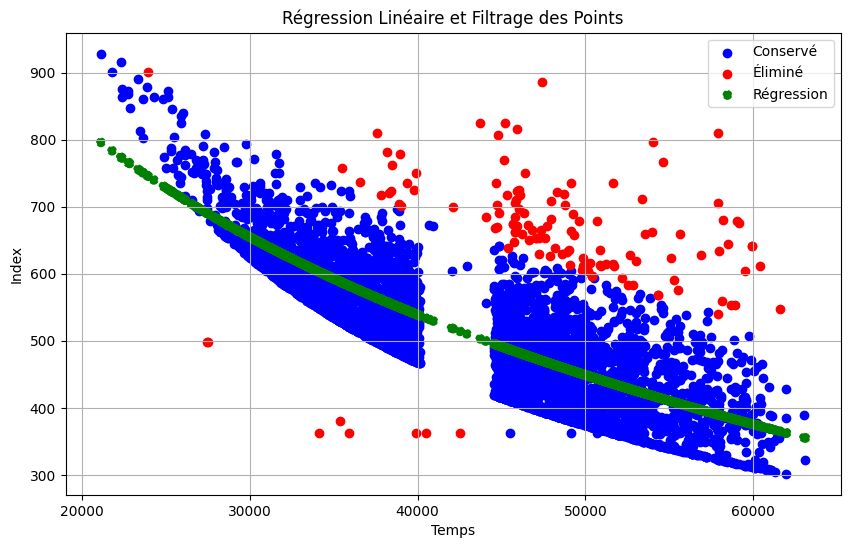

In [23]:
# Après vérification, l'index semble plutôt linéaire par rapport au log du temps que le temps. 
# Ce n'est pas parfait, mais pour notre cas d'usage cette approximation semble suffisante.

# régression linéaire
X = np.log(race_results_df.dropna()[["temps"]])
y = race_results_df.dropna()["index"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Filtrage
residu = y - y_pred
conserve = residu.abs() <= 150

# Plot
plt.figure(figsize=(10, 6))
conservés = race_results_df.dropna()[conserve]
plt.scatter(conservés["temps"], conservés["index"], color="blue", label="Conservé")
éliminés = race_results_df.dropna()[~conserve]
plt.scatter(éliminés["temps"], éliminés["index"], color="red", label="Éliminé")

# Ajouter la droite de régression
plt.scatter(race_results_df.dropna()["temps"], y_pred, color="green", linestyle="--", label="Régression")

plt.xlabel("Temps")
plt.ylabel("Index")
plt.title("Régression Linéaire et Filtrage des Points")
plt.legend()
plt.grid()

plt.show()

Afin de pouvoir conserver des statistiques de course de la meilleure qualité possible, on ne va pas supprimer les athlètes à ITRA manquant ou faux, mais simplement ajouter un tag pour les identifier pour nos analyses à venir.

In [24]:
race_results_df["index_correct"] = 1
race_results_df.loc[éliminés.index, "index_correct"] = 0
race_results_df.loc[race_results_df.isna().any(axis=1), "index_correct"] = 0

## 4. Sauvegarder les données processées

In [25]:
if SAVE:
    race_results_df.to_csv(CLEAN_DATA_PATH / "race_results.csv", index=False)
    meteo_df.to_csv(CLEAN_DATA_PATH / "meteo.csv", index=False)

# END OF NOTEBOOK